# Handling netcdf data with Xarray
#### How to create publishable netCDF data?
Remon Sadikni, remon.sadikni@uni-hamburg.de

## Goal
**We will use in this section of the workshop xarray to write our data to netCDF files because it is very convenient to do so by means of this library. The main idea is to build your data set including attibutes and write it in the end to a file.**


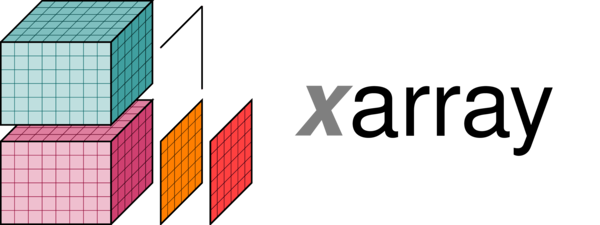

In [5]:
from IPython.display import Image
Image('http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png')

### Overview

* for __N-dimensional arrays__

* for geoscientists who need to use __netCDF__.

* attaches __Dimensions__ indexes and __Coordinate__ names to numpy’s ndarray

Source of this introduction: [Xarray Documentation](http://xarray.pydata.org/en/stable/index.html).

___
### Getting started

In [1]:
# Import standard packages
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff() # turn off interactive plotting mode
import numpy as np
import pandas as pd
# Xarray is conventionally imported as 'xr'
import xarray as xr

___
### Core data structures <a name="data_structures"></a>

Xarray provides two core data structures:

* __DataArray__ is a __labeled, N-dimensional array__ (similar to _pandas.Series_)
    
* __Dataset__ is a multi-dimensional, dict-like __container of DataArray__ objects with shared dimensions (similar to _pandas.DataFrame_)

#### Dataset

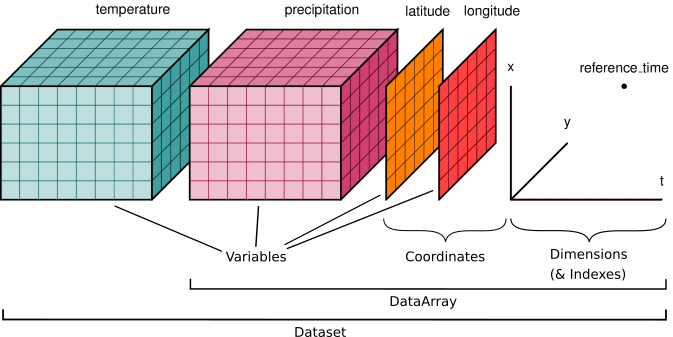

In [12]:
Image('http://xarray.pydata.org/en/stable/_images/dataset-diagram.png')

Datasets have four key properties:

* `dims`: a dictionary mapping from dimension names to the fixed length of each dimension (e.g., `{'x': 6, 'y': 6, 'time': 8}`)
* `data_vars`: a multi-dimensional array of values (e.g., a Numpy ndarray, DataFrame) 
* `coords`: dict-like container of arrays intended to label points used in `data_vars` (e.g., arrays of positional numbers, datetime objects or strings)
* `attrs`: a dict to hold arbitrary metadata

#### Creating a Dataset

In [2]:
# Make up dummy temperature and precip data_vars for four locations

### negativbeispiel? lieber stations? H.2.1 CF anhang
temp = 15 + 8 * np.random.rand(12, 2, 2) # 3 dim array (time, lat, lon)
precip = 10 * np.random.rand(12, 2, 2) 

# Set up arbitrary coordinates
times = pd.date_range('2000', freq='a', periods=12)
lons = [[-99.83, -90.32], [-80.79, -75.23]]
lats = [[42.25, 41.21], [40.63, 39.59]]

# Construct a Dataset
ds = xr.Dataset(data_vars={'temperature': (['time', 'y', 'x'],  temp),
                           'precipitation': (['time', 'y', 'x'],  precip),},
                coords={'lon': (['y', 'x'], lons),
                        'lat': (['y', 'x'], lats),
                        'time': ('time', times),})


<IPython.core.display.Javascript object>


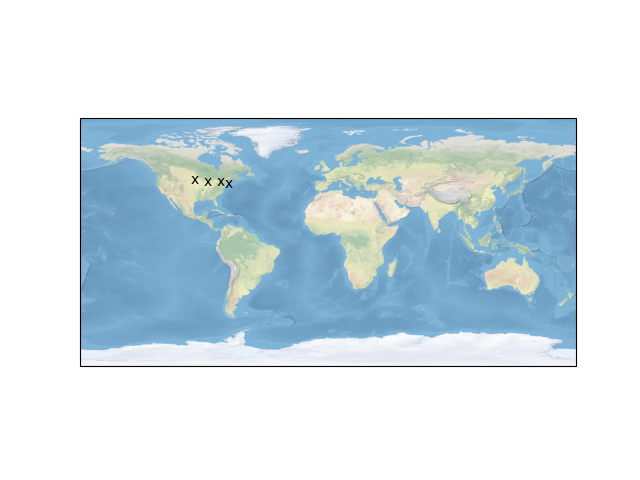

In [5]:
# Cartopy (just to show the locations on a map)
import cartopy as cp
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
for lon, lat in zip(np.array(lons).flatten(), np.array(lats).flatten()):
    plt.text(lon, lat, 'x')

plt.show()    

#### Overview of the Dataset:
ncdump-like:

In [16]:
ds.info()

xarray.Dataset {
dimensions:
	time = 12 ;
	y = 2 ;
	x = 2 ;

variables:
	float64 temperature(time, y, x) ;
	float64 precipitation(time, y, x) ;
	float64 lon(y, x) ;
	float64 lat(y, x) ;
	datetime64[ns] time(time) ;

// global attributes:
}

In [17]:
print(ds) # different way to get an overview of the dataset

<xarray.Dataset>
Dimensions:        (time: 12, y: 2, x: 2)
Coordinates:
    lon            (y, x) float64 -99.83 -90.32 -80.79 -75.23
    lat            (y, x) float64 42.25 41.21 40.63 39.59
  * time           (time) datetime64[ns] 2000-12-31 2001-12-31 ... 2011-12-31
Dimensions without coordinates: y, x
Data variables:
    temperature    (time, y, x) float64 18.91 22.9 15.51 ... 18.13 21.6 18.13
    precipitation  (time, y, x) float64 4.786 1.204 7.549 ... 5.073 2.558 6.576


#### Access the DataArray objects

In [18]:
ds['temperature'] # label-based indexing

<xarray.DataArray 'temperature' (time: 12, y: 2, x: 2)>
array([[[18.90872722, 22.89895985],
        [15.51344235, 21.71712166]],

       [[18.96793491, 19.56915414],
        [15.0753807 , 19.56693041]],

       [[22.84236541, 17.11917893],
        [18.61234792, 16.03849637]],

       [[16.35118575, 15.32946306],
        [17.67543886, 21.75127264]],

       [[21.86400589, 16.05515902],
        [17.36684855, 21.02773581]],

       [[17.0490439 , 19.64386955],
        [15.62228332, 22.06264072]],

       [[21.18805982, 21.53482104],
        [18.15002086, 17.13113779]],

       [[15.84448346, 15.85973698],
        [15.25936802, 21.76907888]],

       [[21.97347288, 21.15578233],
        [18.34530905, 16.83228152]],

       [[15.94275942, 17.20939557],
        [21.95622093, 21.19193273]],

       [[15.13126313, 15.3171979 ],
        [22.90776731, 19.71849577]],

       [[20.0374359 , 18.12578729],
        [21.60416891, 18.12893294]]])
Coordinates:
    lon      (y, x) float64 -99.83 -90.32 -80.79 -75.23
    lat      (y, x) float64 42.25 41.21 40.63 39.59
  * time     (time) datetime64[ns] 2000-12-31 2001-12-31 ... 2011-12-31
Dimensions without coordinates: y, x

#### Add Metadata

In [19]:
ds['temperature'].attrs = {'units': 'degC', 'shortname': 'temp'}
ds['precipitation'].attrs = {'units': 'mm a-1', 'shortname': 'precip'}

ds.attrs = {'description': 'Random precipitation and temperature data', 
            'contact': 'remon.sadikni@uni-hamburg.de', 
            'institution': 'ICDC, CEN, University Hamburg'}

In [20]:
ds.info()

xarray.Dataset {
dimensions:
	time = 12 ;
	y = 2 ;
	x = 2 ;

variables:
	float64 temperature(time, y, x) ;
		temperature:units = degC ;
		temperature:shortname = temp ;
	float64 precipitation(time, y, x) ;
		precipitation:units = mm a-1 ;
		precipitation:shortname = precip ;
	float64 lon(y, x) ;
	float64 lat(y, x) ;
	datetime64[ns] time(time) ;

// global attributes:
	:description = Random precipitation and temperature data ;
	:contact = remon.sadikni@uni-hamburg.de ;
	:institution = ICDC, CEN, University Hamburg ;
}

___
### Input / Output <a name="input_output"></a>

You can directly write Xarray objects to disk using `to_netcdf()`

#### Write netCDF file

In [21]:
# Store our dummy dataset in a netCDF file:
ds.to_netcdf('random_temp_precip.nc') # check available arguments for customized output

#### Read netCDF file
Example: NCEP reanalysis data - Monthly 2m air temperature

Don't forget to set the env var:
<pre>export HDF5_USE_FILE_LOCKING=FALSE </pre>

In [22]:
filepath='/data/icdc/reanalyses/ncep_reanalysis1/DATA/'

In [23]:
ds = xr.open_dataset(filepath+'2m_airtemp_monthly/air2m.mon.mean.nc')

In [24]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 94 ;
	lon = 192 ;
	time = 904 ;

variables:
	float32 lat(lat) ;
		lat:units = degrees_north ;
		lat:actual_range = [ 88.542 -88.542] ;
		lat:long_name = Latitude ;
		lat:standard_name = latitude ;
		lat:axis = Y ;
	float32 lon(lon) ;
		lon:units = degrees_east ;
		lon:long_name = Longitude ;
		lon:actual_range = [  0.    358.125] ;
		lon:standard_name = longitude ;
		lon:axis = X ;
	datetime64[ns] time(time) ;
		time:long_name = Time ;
		time:delta_t = 0000-01-00 00:00:00 ;
		time:avg_period = 0017-00-00 00:00:00 ;
		time:prev_avg_period = 0000-00-01 00:00:00 ;
		time:standard_name = time ;
		time:axis = T ;
		time:actual_range = [1297320. 1956936.] ;
	float32 air(time, lat, lon) ;
		air:long_name = Monthly Mean of Air Temperature ;
		air:valid_range = [150. 400.] ;
		air:units = degK ;
		air:precision = 2 ;
		air:GRIB_id = 11 ;
		air:GRIB_name = TMP ;
		air:var_desc = Air temperature ;
		air:level_desc = 2 m ;
		air:statistic = Mean ;
		air:parent_s

#### Read multiple netCDF files
Read in u- and v-component of NCEP 10m wind data.

In [25]:
dswind = xr.open_mfdataset([filepath+'u_wind_monthly/uwnd10m.mon.mean.nc',filepath+'v_wind_monthly/vwnd10m.mon.mean.nc'])

In [26]:
print(dswind)

<xarray.Dataset>
Dimensions:  (lat: 94, lon: 192, time: 904)
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-04-01
Data variables:
    uwnd     (time, lat, lon) float32 dask.array<chunksize=(904, 94, 192), meta=np.ndarray>
    vwnd     (time, lat, lon) float32 dask.array<chunksize=(904, 94, 192), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    NCO:            20121013
    history:        renamevars Thu Feb  1 09:41:58 2001 from uwnd10m.mon.mean...
    title:          monthly mean uwnd.10m from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...


In [27]:
ds.where(ds['air'] > 300)

<xarray.Dataset>
Dimensions:  (time: 904, lat: 94, lon: 192)
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-04-01
Data variables:
    air      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:    COARDS
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    NCO:            20121012
    history:        created 97/10/04 by Hoop (netCDF2.3)\nConverted to chunke...
    title:          monthly mean air.2m from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

* One can apply Xarray functions from imported library (via `xr`).

__Example:__ Set all values below 10 degC to 0 (`x`) and above to 1 (`y`) using `xr.where` function.

In [29]:
xr.where(ds['air'] > 280, x=1, y=0)

<xarray.DataArray 'air' (time: 904, lat: 94, lon: 192)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-04-01

### Links <a name="exercises_links"></a>
* [Offical Xarray Documentation](http://xarray.pydata.org/en/stable/index.html)
* [Other Python Packages build upon Xarray](http://xarray.pydata.org/en/stable/faq.html#what-other-projects-leverage-xarray)
* [Pangeo - Project on Big Data geosciences backing Xarray](https://pangeo-data.github.io/)

#### This was only an introduction to Xarray. There are many more features left to be explored. Xarray developers are very active and currently release new versions on a monthly basis!